# **Análisis de los resultados a partir del modelamiento:**

In [1]:
!pip install pyspark
!apt install openjdk-11-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=56cfc0a23714c0910f78f92a32f7e0bbfe2b3644e9516d02daece8becb83da5f
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
openjdk-11-jdk-headless is already the newest version (11.0.19+7~us1-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **Configuración y creación de la sesión de spark:**

In [3]:
conf = SparkConf().set("spark.ui.port", "4050")

sc = SparkContext(conf = conf)
spark = (
    SparkSession.builder
    .master('local[*]')
    .config("spark.driver.memory", "10g")
    .config("spark.executor.memory", "10g")
    .getOrCreate()
)

spark

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Cargando los conjuntos de datos:**

### *Datos de las reseñadas procesados:*

In [5]:
PATH_REVIEWS_OUT = r"/content/drive/Shareddrives/MSc Ciencia Datos/Mineria/data/"
PATH_REVIEWS_FILE = r"processed_reviews.parquet"
features_reviews = spark.read.parquet(PATH_REVIEWS_OUT + PATH_REVIEWS_FILE).cache()

In [6]:
print(features_reviews.count())
features_reviews.show(10)

66064
+--------------+--------------------+--------------------+----------+--------------------+--------------------+-----+----------+-----------+-------------+-----------+----+-----------------+-----------+
|     review_id|         review_body|      refined_tokens|num_tokens|         tf_features|            features|  uid|product_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_date|
+--------------+--------------------+--------------------+----------+--------------------+--------------------+-----+----------+-----------+-------------+-----------+----+-----------------+-----------+
|R100D9FYS3YY7A|no prizes for gue...|[prize, guess, in...|        17|(200,[13,23,48,52...|(200,[13,23,48,52...|14591|B000EJUQ1U|          5|            2|          2|   N|                N| 2013-08-17|
|R100N1N9XDI0XO|from the back of ...|[back, facet, vid...|        75|(200,[1,4,7,9,12,...|(200,[1,4,7,9,12,...|59280|B00000F713|          4|            1|          2|   N|               

### *Datos de las reseñadas tipificadas según LDA:*

In [7]:
PATH_LDA_OUT = r"/content/drive/Shareddrives/MSc Ciencia Datos/Mineria/data/"
PATH_LDA_FILE = r"lda_reviews.parquet"
modeled_reviews = spark.read.parquet(PATH_LDA_OUT + PATH_LDA_FILE).cache()

In [8]:
print(modeled_reviews.count())
modeled_reviews.show(10)

66064
+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+--------------------+-----------+----------+
|     review_id|         review_body|      refined_tokens|num_tokens|         tf_features|            features|uid|   topicDistribution|main_topics|main_topic|
+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+--------------------+-----------+----------+
|R106N066IUN8ZV|kevin kline is th...|[kevin, kline, ve...|        17|(200,[2,26,40,60,...|(200,[2,26,40,60,...|  0|[0.50044636182885...|     [0, 1]|         0|
| RWT3H6HBVAL6G|y'know what this ...|[yknow, remind, s...|        63|(200,[0,2,6,11,22...|(200,[0,2,6,11,22...|  1|[0.49872383113982...|     [1, 0]|         1|
| RGORN81H45NI7|this is the best ...|[best, exercis, v...|        22|(200,[3,74,77,82,...|(200,[3,74,77,82,...|  2|[0.49929721323105...|     [1, 0]|         1|
|R343CPRI4MC9J0|i loved this vide.

### *Join de los conjuntos de datos:*

In [9]:
def_df_reviews = features_reviews.join(
    modeled_reviews.select("review_id","topicDistribution", "main_topic"),
    "review_id", how = 'left'
)

def_df_reviews.show(10)

+--------------+--------------------+--------------------+----------+--------------------+--------------------+-----+----------+-----------+-------------+-----------+----+-----------------+-----------+--------------------+----------+
|     review_id|         review_body|      refined_tokens|num_tokens|         tf_features|            features|  uid|product_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_date|   topicDistribution|main_topic|
+--------------+--------------------+--------------------+----------+--------------------+--------------------+-----+----------+-----------+-------------+-----------+----+-----------------+-----------+--------------------+----------+
|R1008GWETRFID1|filmed in canada ...|[film, canada, ea...|        20|(200,[3,4,22,40,4...|(200,[3,4,22,40,4...|51866|1569382506|          5|            4|          4|   N|                Y| 2008-04-16|[0.49966205859843...|         1|
|R100GCI6ADKWZ0|my mother loves t...|[mother, love, co...|      

In [10]:
def_df_reviews.count()

66064

## **Análisis de los resultados obtenidos:**

### *Cantidad de reseñas por tópico:*

In [11]:
count_per_topic = def_df_reviews.groupBy("main_topic").count()
pd_count_per_topic = count_per_topic.toPandas()

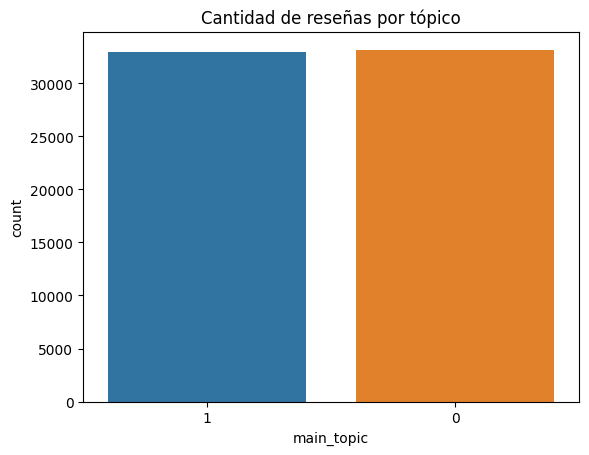

In [12]:
sns.barplot(
    x = pd_count_per_topic['main_topic'].astype(str),
    y = pd_count_per_topic['count']
)
plt.title("Cantidad de reseñas por tópico")
plt.show()

### *Cantidad de estrellas obtenidas:*

In [13]:
star_per_topic = def_df_reviews.groupBy("main_topic", "star_rating").count()
pd_star_per_topic = star_per_topic.toPandas()

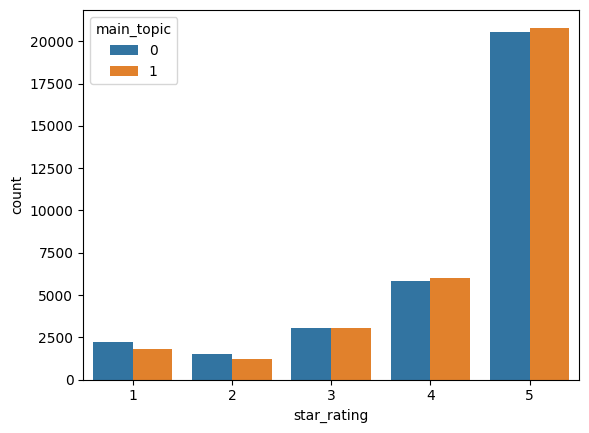

In [14]:
sns.barplot(
    data = pd_star_per_topic.sort_values(by = 'star_rating'),
    x = "star_rating",
    y = "count",
    hue = "main_topic"
)

plt.show()

In [15]:
dist_star_per_topic = def_df_reviews.select("star_rating", "main_topic")
pd_dist_star_per_topic = dist_star_per_topic.toPandas()

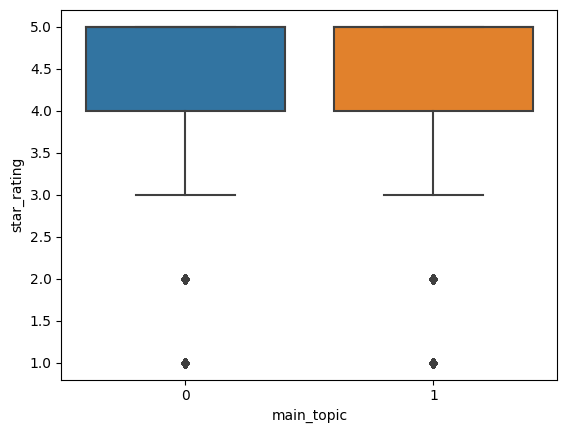

In [16]:
sns.boxplot(
    x = pd_dist_star_per_topic["main_topic"].astype(str),
    y = pd_dist_star_per_topic['star_rating'].astype(int)
)

plt.show()

### *Compras verificadas por tópico detectado:*

In [17]:
purchases_per_topic = def_df_reviews.groupBy("main_topic", "verified_purchase").count()
pd_purchases_per_topic = purchases_per_topic.toPandas()

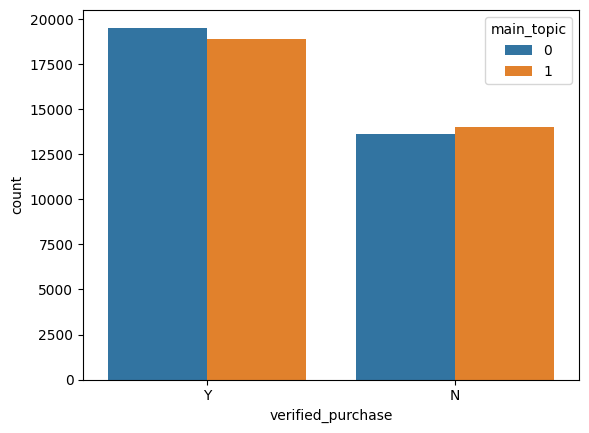

In [18]:
sns.barplot(
    data = pd_purchases_per_topic,
    x = "verified_purchase",
    y = "count",
    hue = "main_topic"
)

plt.show()

### *Número de tokens en una reseña, por tópico:*

In [19]:
num_tokens_per_topic = def_df_reviews.select("num_tokens", "main_topic")
pd_num_tokens_per_topic = num_tokens_per_topic.toPandas()
pd_num_tokens_per_topic.head()

,num_tokens,main_topic
0,14,0
1,16,0
2,86,0
3,78,1
4,73,1


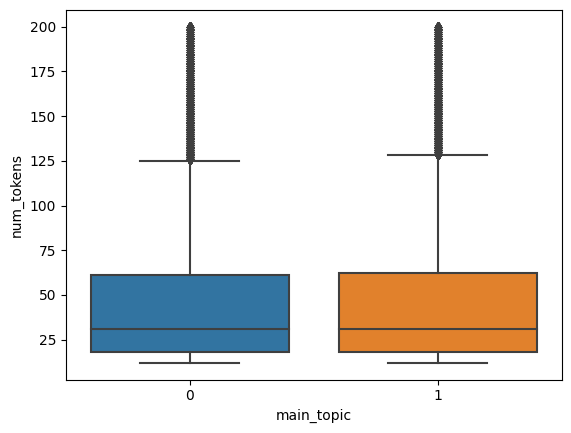

In [20]:
sns.boxplot(
    data = pd_num_tokens_per_topic,
    x = "main_topic",
    y = 'num_tokens'
)

plt.show()

### *Frecuencia de Tokens por tópico:*

In [21]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('punkt')

def top20_tf(df, input_col):
    tokens = []

    for token_list in df.select(input_col).collect():
        stg_str = token_list.__getitem__(input_col)
        tokens += stg_str

    fdist = nltk.FreqDist(tokens)
    print(f'Tamaño del bag of words: {len(fdist)}')

    topwords = fdist.most_common(20)
    
    x,y = zip(*topwords)
    plt.figure(figsize=(8, 6))
    plt.barh(x,y)
    plt.gca().invert_yaxis()
    plt.show()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
df_tokens_topics = def_df_reviews.select("review_id", "refined_tokens", "main_topic")

df_tokens_topics.show(3)

+--------------+--------------------+----------+
|     review_id|      refined_tokens|main_topic|
+--------------+--------------------+----------+
|R1008GWETRFID1|[film, canada, ea...|         1|
|R100D9FYS3YY7A|[prize, guess, in...|         0|
|R100GCI6ADKWZ0|[mother, love, co...|         1|
+--------------+--------------------+----------+
only showing top 3 rows



Tamaño del bag of words: 108716


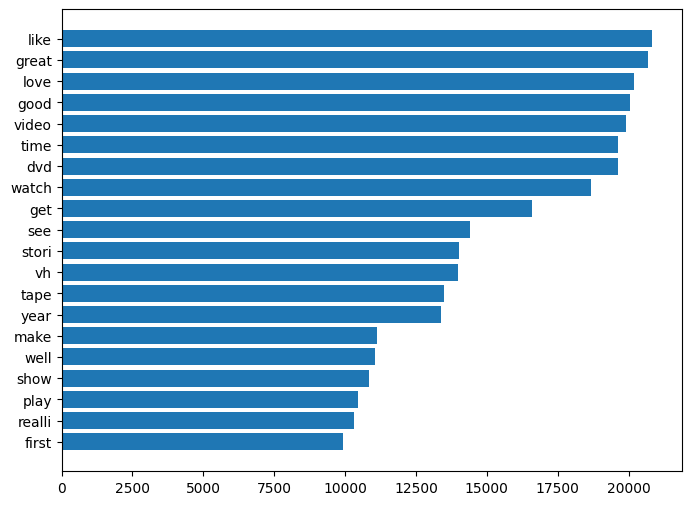

In [23]:
top20_tf(df_tokens_topics, 'refined_tokens')

In [24]:
unique_topics = df_tokens_topics.select(collect_list('main_topic')).first()[0]
unique_topics = set(unique_topics)
unique_topics

{0, 1}

Top 20 Tokens para el tópico: 0

Tamaño del bag of words: 68967


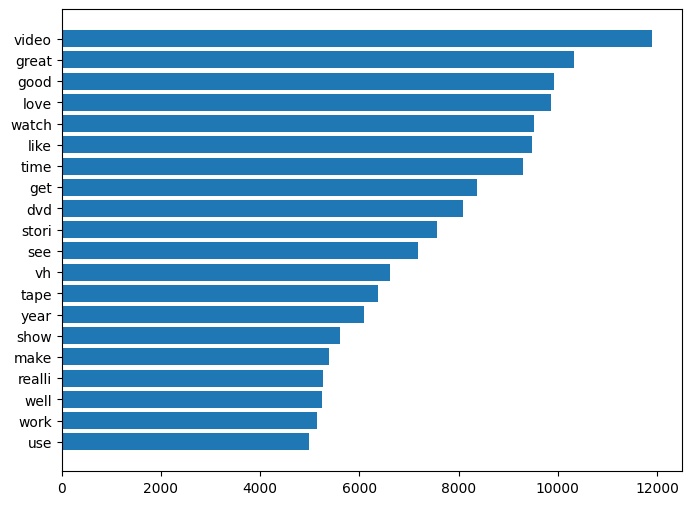

Top 20 Tokens para el tópico: 1

Tamaño del bag of words: 71858


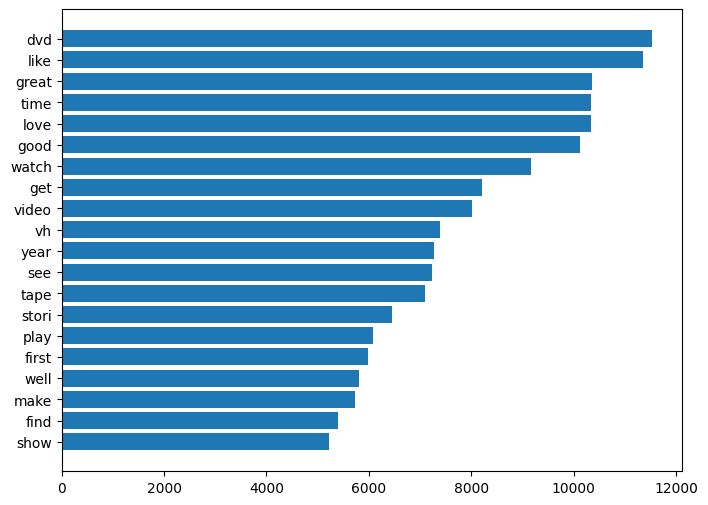

In [25]:
for topic in unique_topics:
    
    filter_string = f'main_topic == {topic}'
    print(f'Top 20 Tokens para el tópico: {topic}\n')
    
    top20_tf(df_tokens_topics.filter(filter_string), 'refined_tokens')